In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#Get dataset
url = 'https://raw.githubusercontent.com/tannerskluz/SpotifyClassifier/main/data.csv'
df = pd.read_csv(url)
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [3]:
#drop non-numeric attributes
df.drop(columns=['id', 'name', 'artists', 'release_date'],inplace=True)
df.shape

(174389, 15)

In [4]:
#analyze data
df['explicit'].value_counts()

0    162507
1     11882
Name: explicit, dtype: int64

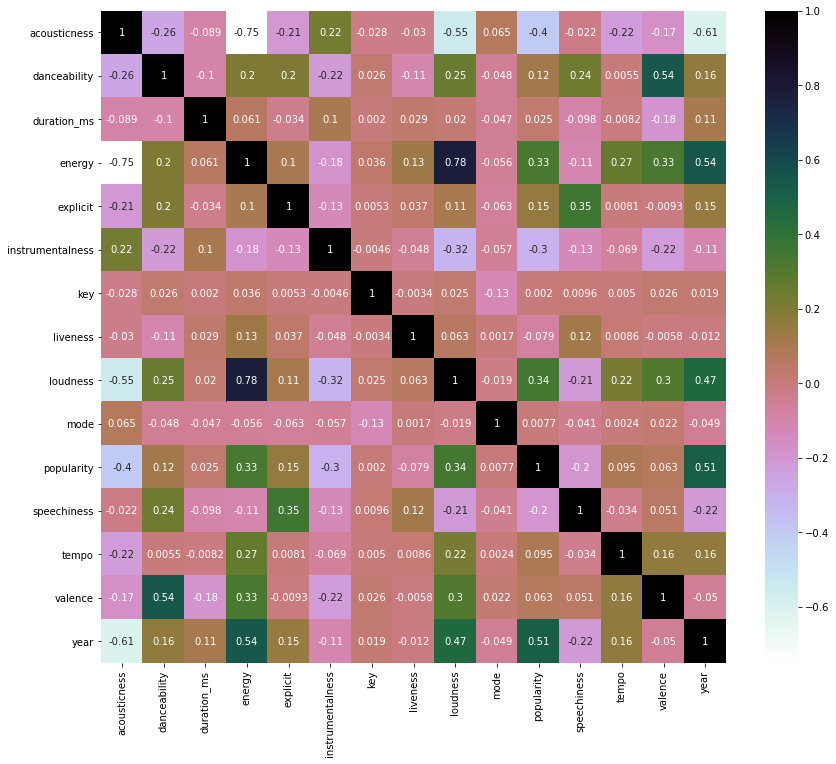

In [5]:
plt.figure(figsize=(14,12)) 
sns.heatmap(df.corr(), annot=True, cmap='cubehelix_r')
plt.show()

#### Testing with off the shelf Gaussian NB Classifier

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [7]:
X = df.drop('explicit', axis=1)
y = df['explicit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [8]:
clf_nb = GaussianNB()

In [9]:
clf_nb.fit(X_train, y_train)

GaussianNB()

In [10]:
y_pred = clf_nb.predict(X_test)

In [11]:
print('Accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {}'.format(precision_score(y_test, y_pred)))
print('Recall score: {}'.format(recall_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))

Accuracy score: 0.9301565456734905
Precision score: 0.28936170212765955
Recall score: 0.029097133076593923
F1 score: 0.05287713841368585


In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [13]:
#show auc roc curve
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

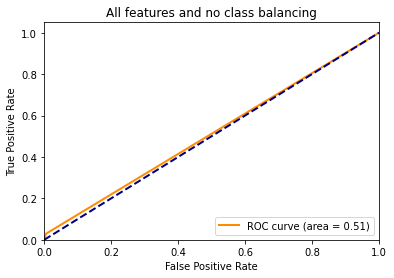

In [14]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All features and no class balancing')
plt.legend(loc="lower right")
plt.show()

#### Accounting for class imbalance problem

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
X = df.drop('explicit', axis=1)
y = df['explicit']

In [17]:
sm = SMOTE(random_state=0, sampling_strategy='minority')
X_res, y_res = sm.fit_resample(X, y)

In [18]:
X_res.shape

(325014, 14)

In [19]:
y_res.shape

(325014,)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.20)

In [21]:
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)

GaussianNB()

In [22]:
y_pred = clf_nb.predict(X_test)

In [23]:
print('Accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {}'.format(precision_score(y_test, y_pred)))
print('Recall score: {}'.format(recall_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))

Accuracy score: 0.6873528914050121
Precision score: 0.6718824754453606
Recall score: 0.7337267195279366
F1 score: 0.7014440804454173


In [24]:
#show auc roc curve
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

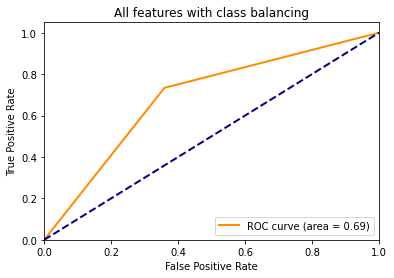

In [25]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All features with class balancing')
plt.legend(loc="lower right")
plt.show()

#### Removing redundant and irrelevant attributes

In [26]:
df_reduced = df.drop(columns=['duration_ms', 'key', 'liveness', 'mode', 'tempo', 'valence',
                      'loudness', 'instrumentalness'])
df_reduced.head()

,acousticness,danceability,energy,explicit,popularity,speechiness,year
0,0.991000,0.598,0.224,0,12,0.0936,1920
1,0.643000,0.852,0.517,0,7,0.0534,1920
2,0.993000,0.647,0.186,0,4,0.1740,1920
3,0.000173,0.730,0.798,0,17,0.0425,1920
4,0.295000,0.704,0.707,1,2,0.0768,1920


In [27]:
X = df_reduced.drop('explicit', axis=1)
y = df_reduced['explicit']

In [28]:
sm = SMOTE(random_state=0, sampling_strategy='minority')
X_res, y_res = sm.fit_resample(X, y)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.20)

In [30]:
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)

GaussianNB()

In [31]:
y_pred = clf_nb.predict(X_test)

In [32]:
print('Accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {}'.format(precision_score(y_test, y_pred)))
print('Recall score: {}'.format(recall_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))

Accuracy score: 0.812147131670846
Precision score: 0.7698815115286081
Recall score: 0.8893855781977371
F1 score: 0.8253300719506788


In [33]:
#show auc roc curve
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

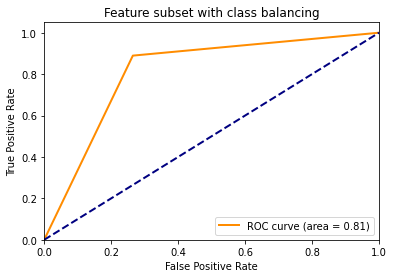

In [34]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Feature subset with class balancing')
plt.legend(loc="lower right")
plt.show()

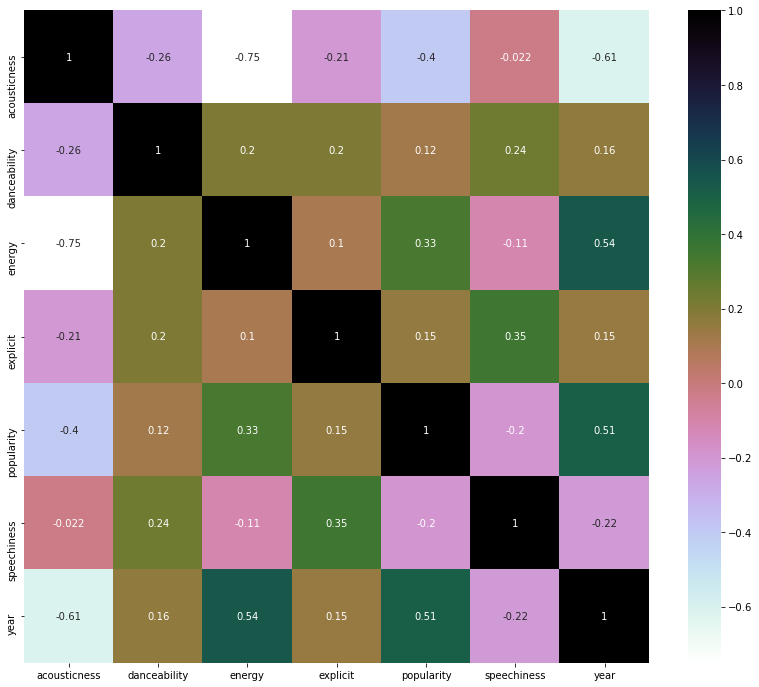

In [35]:
plt.figure(figsize=(14,12)) 
sns.heatmap(df_reduced.corr(), annot=True, cmap='cubehelix_r')
plt.show()